# TBR measurements

In [1]:
# download data from runs 100mL and runs 1, 2, 3
tbr_data = {
    "100ml_4": 3.42e-4,
    "100ml_5": 3.57e-4,
    "100ml_6": 3.83e-4,
}

neutron_fluence_data_100ml = {
    "100ml_4": 3.17e13,
    "100ml_5": 3.35e13,
    "100ml_6": 3.06e13,
}

modelled_tbr_100ml = 4.71e-4

import requests
import json


def get_data(url):
    # read json file from url
    response = requests.get(url)
    if response.status_code == 200:
        print("Download successful!")
        return json.loads(response.content.decode("utf-8"))
    else:
        print(f"Failed to download file. HTTP Status Code: {response.status_code}")
        return None


data_1l_run_1 = get_data(
    "https://raw.githubusercontent.com/LIBRA-project/BABY-1L-run-1/refs/heads/main/data/processed_data.json"
)
data_1l_run_2 = get_data(
    "https://raw.githubusercontent.com/LIBRA-project/BABY-1L-run-2/refs/heads/main/data/processed_data.json"
)
data_1l_run_3 = get_data(
    "https://raw.githubusercontent.com/LIBRA-project/BABY-1L-run-3/refs/heads/main/data/processed_data.json"
)
data_1l_run_4 = get_data(
    "https://raw.githubusercontent.com/LIBRA-project/BABY-1L-run-4/refs/heads/main/data/processed_data.json"
)

Download successful!
Download successful!
Download successful!
Download successful!


In [2]:
from libra_toolbox.tritium import ureg
from libra_toolbox.tritium.model import activity_to_quantity


def get_total_irradiation_time(data: dict) -> float:
    duration = 0
    irradiations = data["irradiations"]
    for irr in irradiations:
        start = irr["start_time"]["value"] * ureg(irr["start_time"]["unit"])
        end = irr["stop_time"]["value"] * ureg(irr["stop_time"]["unit"])
        duration += (end - start).to(ureg("s")).magnitude
    return duration


def get_neutron_fluence(data):
    # get neutron fluence from data
    irradiation_time = get_total_irradiation_time(data)
    neutron_rate = data["neutron_rate_used_in_model"]["value"] * ureg(
        data["neutron_rate_used_in_model"]["unit"]
    )
    neutron_rate = neutron_rate.to(ureg("neutron/s")).magnitude
    neutron_fluence = neutron_rate * irradiation_time
    return neutron_fluence


def get_total_tritium_prod(data, nb_samples_included_IV=-1, nb_samples_included_OV=-1) -> float:
    cumul_release = data["cumulative_tritium_release"]
    IV = cumul_release["IV"]["total"]
    OV = cumul_release["OV"]["total"]
    total_t = IV["value"][nb_samples_included_IV] * ureg(IV["unit"]) + OV["value"][nb_samples_included_OV] * ureg(OV["unit"])
    total_t = activity_to_quantity(total_t).to(ureg.particle).magnitude
    return total_t


In [3]:
import numpy as np

# Extract TBR data for 100 mL
measured_tbr_100ml = np.mean(list(tbr_data.values()))

modelled_tbr_1l = data_1l_run_1.get("modelled_TBR", {}).get("mean", None)

total_neutron_fluence_1l = sum(
    [
        get_neutron_fluence(data_1l_run_1),
        get_neutron_fluence(data_1l_run_2),
        get_neutron_fluence(data_1l_run_3),
        get_neutron_fluence(data_1l_run_4),
    ]
)
total_tritium_production_1l = sum(
    [
        get_total_tritium_prod(data_1l_run_1),
        get_total_tritium_prod(data_1l_run_2),
        get_total_tritium_prod(data_1l_run_3),
        get_total_tritium_prod(data_1l_run_4, nb_samples_included_IV=9, nb_samples_included_OV=0),
    ]
)

measured_tbr_1l = total_tritium_production_1l / total_neutron_fluence_1l

In [4]:
import pandas as pd

# Create a dictionary with the TBR data
data_dict = {
    "100 mL": {
        "measured_tbr": measured_tbr_100ml,
        "modelled_tbr": modelled_tbr_100ml,
    },
    "1 L (all)": {
        "measured_tbr": measured_tbr_1l,
        "modelled_tbr": modelled_tbr_1l,
        "neutron_fluence": total_neutron_fluence_1l,
        "tritium_production": total_tritium_production_1l,
    },
    "1L run 1": {
        "measured_tbr": data_1l_run_1.get("measured_TBR", {}).get("value", None),
        "modelled_tbr": data_1l_run_1.get("modelled_TBR", {}).get("mean", None),
        "neutron_fluence": get_neutron_fluence(data_1l_run_1),
        "tritium_production": get_total_tritium_prod(data_1l_run_1),
    },
    "1L run 2": {
        "measured_tbr": data_1l_run_2.get("measured_TBR", {}).get("value", None),
        "modelled_tbr": data_1l_run_2.get("modelled_TBR", {}).get("mean", None),
        "neutron_fluence": get_neutron_fluence(data_1l_run_2),
        "tritium_production": get_total_tritium_prod(data_1l_run_2),
    },
    "1L run 3": {
        "measured_tbr": data_1l_run_3.get("measured_TBR", {}).get("value", None),
        "modelled_tbr": data_1l_run_3.get("modelled_TBR", {}).get("mean", None),
        "neutron_fluence": get_neutron_fluence(data_1l_run_3),
        "tritium_production": get_total_tritium_prod(data_1l_run_3),
    },
    "1L run 4": {
        "measured_tbr": data_1l_run_4.get("measured_TBR", {}).get("value", None),
        "modelled_tbr": data_1l_run_4.get("modelled_TBR", {}).get("mean", None),
        "neutron_fluence": get_neutron_fluence(data_1l_run_4),
        "tritium_production": get_total_tritium_prod(data_1l_run_4, nb_samples_included_IV=9, nb_samples_included_OV=0),
    },
}

# Create a DataFrame
df_tbr = pd.DataFrame.from_dict(data_dict, orient="index")

# Display the DataFrame
display(df_tbr)

,measured_tbr,modelled_tbr,neutron_fluence,tritium_production
100 mL,0.000361,0.000471,NaN,NaN
1 L (all),0.002137,0.002040,4.573714e+13,9.775648e+10
1L run 1,0.002391,0.002040,3.951072e+12,9.446719e+09
1L run 2,0.001782,0.002040,3.010608e+13,5.364215e+10
1L run 3,0.004054,0.002040,4.500144e+12,1.658573e+10
1L run 4,0.002480,0.002040,7.179840e+12,1.808188e+10


In [5]:
# export df_tbr to latex

def format_scientific_notation(number):
    """Formats a number in scientific notation for LaTeX with times 10."""
    # check if Nan
    if pd.isna(number):
        return "NaN"
    exponent = np.floor(np.log10(number))
    mantissa = number / 10**exponent
    return f"${mantissa:.2f} \\times 10^{{{int(exponent)}}}$"

def dataframe_to_latex_scientific(df, filename="output.tex", include_index=False, caption=None, label=None, column_format=None):
    """
    Exports a Pandas DataFrame to LaTeX, formatting numbers in scientific notation.
    
    Parameters:
    - df: DataFrame to export
    - filename: Output file path
    - include_index: Whether to include the DataFrame index
    - caption: Table caption
    - label: Table reference label
    - column_format: LaTeX column format string
    """
    
    df_formatted = df.copy()
    for col in df_formatted.select_dtypes(include=np.number).columns:
        df_formatted[col] = df_formatted[col].apply(format_scientific_notation)
    
    latex_string = df_formatted.to_latex(
        index=include_index, 
        escape=False,
        caption=caption,
        label=label,
        column_format=column_format
    )
    
    with open(filename, "w") as tex_file:
        tex_file.write(latex_string)

dataframe_to_latex_scientific(
    df_tbr, 
    "tbr_table.tex", 
    include_index=True,
    caption="Tritium Breeding Ratio (TBR) for different runs and volumes.",
    label="tab:tbr",
    column_format="lcccccc"
)


In [6]:
import morethemes as mt

mt.set_theme("minimal")

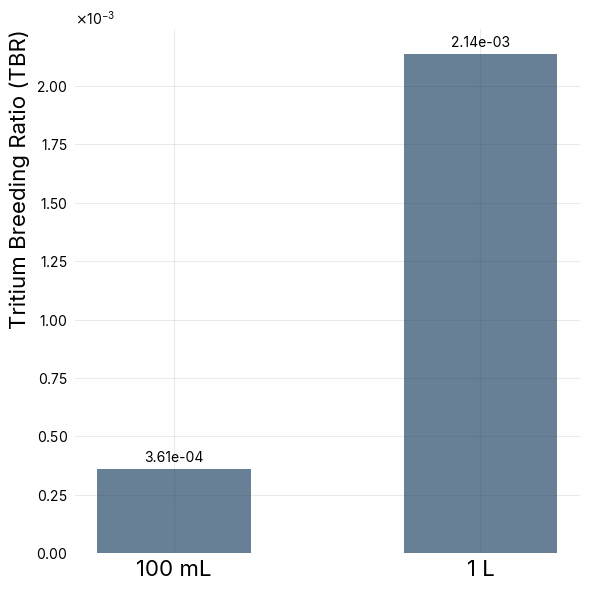

In [7]:
# plot of TBRs for 100 mL and 1L + comparison with OpenMC
from matplotlib.ticker import ScalarFormatter
import matplotlib.pyplot as plt

# Set up the data
x = np.arange(2)  # Two positions for 100 mL and 1L
width = 0.5  # Width of the bars

fig, ax = plt.subplots(figsize=(6, 6))

# Create the bars
measured_bars = ax.bar(
    x,
    [measured_tbr_100ml, measured_tbr_1l],
    width,
    label="Measured",
)


# Set up scientific notation for y-axis
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-3, -3))  # Force power of -3
ax.yaxis.set_major_formatter(formatter)

# Add labels, title and custom x-axis tick labels
ax.set_ylabel("Tritium Breeding Ratio (TBR)", fontsize=16)
# ax.set_title("Comparison of Measured vs Modelled TBR", fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(["100 mL", "1 L"], fontsize=16)

# Add value labels using the built-in bar_label method
ax.bar_label(measured_bars, fmt="%.2e", padding=3)


plt.tight_layout()
plt.savefig("tbr_measurements.svg", bbox_inches="tight")
plt.show()

In [8]:
def sci_formatter(x):
    """Formats a number in scientific notation for LaTeX with times 10."""
    # check if Nan
    if pd.isna(x):
        return "NaN"
    exponent = np.floor(np.log10(x))
    mantissa = x / 10**exponent
    return f"${mantissa:.2f} \\times 10^{{{int(exponent)}}}$"

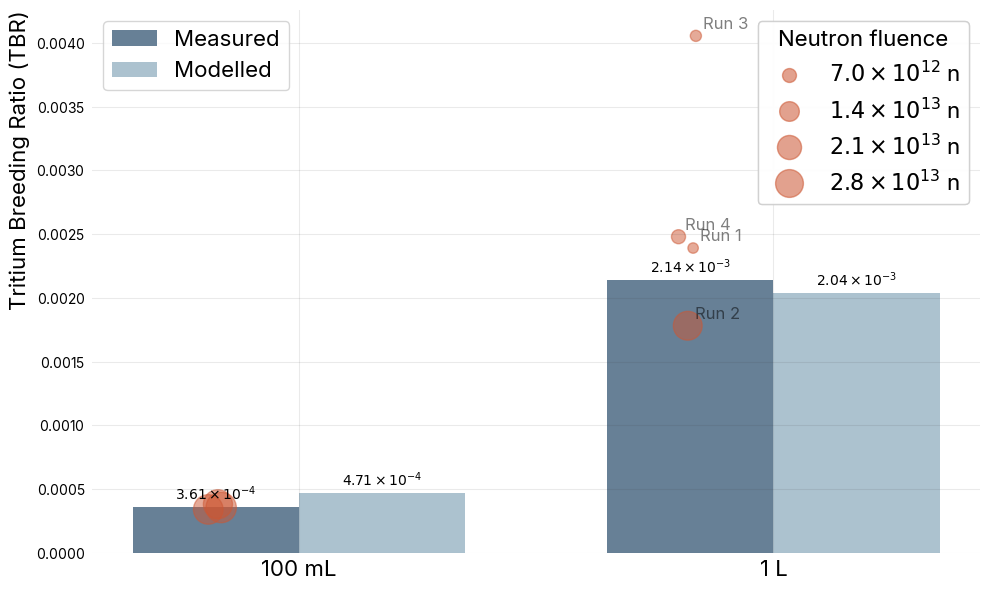

In [24]:
# plot of TBRs for 100 mL and 1L + comparison with OpenMC
from matplotlib.ticker import ScalarFormatter
import matplotlib.pyplot as plt

# Set up the data
x = np.arange(2)  # Two positions for 100 mL and 1L
width = 0.35  # Width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Create the bars
measured_bars = ax.bar(
    x - width / 2,
    [measured_tbr_100ml, measured_tbr_1l],
    width,
    label="Measured",
)


modelled_bars = ax.bar(
    x + width / 2,
    [modelled_tbr_100ml, modelled_tbr_1l],
    width,
    label="Modelled",
)

# scatter plot for 100 mL runs
size_norm_factor = 7e10

x_jitter = np.random.normal(0, 0.04, 3)  # Jitter for x-axis
size = list(neutron_fluence_data_100ml.values())
size = [s / size_norm_factor for s in size]  # Scale down for better visibility
scatter = plt.scatter(
    x=(0 - width / 2) + x_jitter[:3],
    y=list(tbr_data.values()),
    alpha=0.5,
    s=size,
)

# scatter plot for 1L runs

x_jitter = np.random.normal(0, 0.02, 4)  # Jitter for x-axis
# size of the dots proportional to the neutron fluence
size = [
    get_neutron_fluence(data_1l_run_1),
    get_neutron_fluence(data_1l_run_2),
    get_neutron_fluence(data_1l_run_3),
    get_neutron_fluence(data_1l_run_4),
]
size = [s / size_norm_factor for s in size]  # Scale down for better visibility
scatter = plt.scatter(
    x=(1 - width / 2) + x_jitter[:4],
    y=[df_tbr.loc[f"1L run {i}", "measured_tbr"] for i in range(1, 5)],
    alpha=0.5,
    s=size,
    color=scatter.get_facecolor(),
)
for i in range(1, 5):
    plt.annotate(
        f"Run {i}",
        xy=((1 - width / 2) + x_jitter[i-1], df_tbr.loc[f"1L run {i}", "measured_tbr"]),
        xytext=(5, 5),
        fontsize=12,
        textcoords="offset points",
        alpha=0.5,
    )


# Set up scientific notation for y-axis
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
ax.yaxis.set_major_formatter(formatter)

# Add labels, title and custom x-axis tick labels
ax.set_ylabel("Tritium Breeding Ratio (TBR)", fontsize=16)
# ax.set_title("Comparison of Measured vs Modelled TBR", fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(["100 mL", "1 L"], fontsize=16)
ax.legend()

# Add value labels using the built-in bar_label method
ax.bar_label(measured_bars, fmt=sci_formatter, padding=3)
ax.bar_label(modelled_bars, fmt=sci_formatter, padding=3)

# Create size legend with proper normalization factor display
handles, labels = scatter.legend_elements(prop="sizes", num=4)

# Convert the size labels back to actual neutron fluence values
new_labels = []
for label in labels:
    # Extract the numeric value from the label
    size_val = float(label.strip('$').split('{')[1].split('}')[0])
    # Convert back to actual neutron fluence by multiplying by normalization factor
    actual_fluence = size_val * size_norm_factor
    # Format as power of 10 using LaTeX
    exponent = int(np.log10(actual_fluence))
    mantissa = actual_fluence / (10**exponent)
    new_labels.append(f'${mantissa:.1f} \\times 10^{{{exponent}}}$ n')


bar_legend = ax.legend(loc="upper left", fontsize=16)

legend = ax.legend(handles, new_labels, title="Neutron fluence", fontsize=16, title_fontsize=16)

# Color the legend circles
for i, handle in enumerate(legend.legend_handles):
    handle.set_color(scatter.get_facecolor())
    handle.set_alpha(scatter.get_alpha())

ax.add_artist(legend)
ax.add_artist(bar_legend)

plt.tight_layout()
plt.savefig("tbr_comparison.pdf")
plt.show()

In [ ]:
from libra_toolbox.tritium.model import Model


def model_from_json(json_data: dict) -> Model:
    """
    Create a model from JSON data.
    """
    # Extract the relevant data from the JSON
    k_top = json_data["k_top"]["value"] * ureg(json_data["k_top"]["unit"])
    k_wall = json_data["k_wall"]["value"] * ureg(json_data["k_wall"]["unit"])
    neutron_rate = json_data["neutron_rate_used_in_model"]["value"] * ureg(
        json_data["neutron_rate_used_in_model"]["unit"]
    )
    irradiations = [
        (
            irr["start_time"]["value"] * ureg(irr["start_time"]["unit"]),
            irr["stop_time"]["value"] * ureg(irr["stop_time"]["unit"]),
        )
        for irr in json_data["irradiations"]
    ]

    # Create a new model instance with the extracted parameters
    model = Model(
        radius=json_data["modelled_baby_radius"]["value"]
        * ureg(json_data["modelled_baby_radius"]["unit"]),
        height=json_data["modelled_baby_height"]["value"]
        * ureg(json_data["modelled_baby_height"]["unit"]),
        TBR=json_data["TBR_used_in_model"]["value"]
        * ureg(json_data["TBR_used_in_model"]["unit"]),
        k_top=k_top,
        k_wall=k_wall,
        neutron_rate=neutron_rate,
        irradiations=irradiations,
    )

    return model


def scatter_stream(data, stream: str, normalise_by=None, **kwargs):
    data_stream = data["cumulative_tritium_release"][stream]

    sampling_times = data_stream["sampling_times"]["value"] * ureg(
        data_stream["sampling_times"]["unit"]
    )
    cumulative_release = data_stream["total"]["value"] * ureg(
        data_stream["total"]["unit"]
    )
    if normalise_by:
        cumulative_release = cumulative_release / normalise_by
    return plt.scatter(sampling_times, cumulative_release, **kwargs)

/home/remidm/anaconda3/envs/baby-1l-paper/lib/python3.12/site-packages/scipy/integrate/_ivp/base.py:23: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(fun(t, y), dtype=dtype)


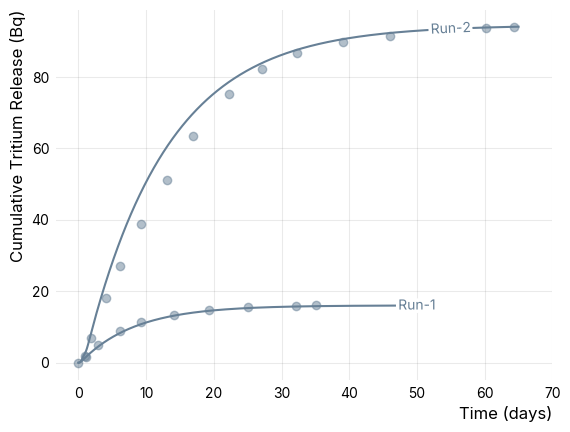

In [ ]:
from libra_toolbox.tritium.plotting import plot_integrated_top_release, plot_irradiation, plot_integrated_wall_release
from labellines import labelLine, labelLines

# run 1
model_run_1 = model_from_json(data_1l_run_1)
model_run_1.run(50 * ureg.day)

(l1,) = plot_integrated_top_release(model_run_1, label="Run-1")
scatter_stream(data_1l_run_1, "IV", color=l1.get_color(), alpha=0.5)

# run 2
model_run_2 = model_from_json(data_1l_run_2)
model_run_2.run(65 * ureg.day)
(l2,) = plot_integrated_top_release(model_run_2, label="Run-2", color=l1.get_color())
scatter_stream(data_1l_run_2, "IV", color=l2.get_color(), alpha=0.5)

# run 3
model_run_3 = model_from_json(data_1l_run_3)
model_run_3.run(50 * ureg.day)
# (l3,) = plot_integrated_top_release(model_run_3, label="Run-3")
# scatter_stream(data_1l_run_3, "IV", color=l3.get_color(), alpha=0.5)

plt.xlim(right=70 * ureg.day)
plt.xlabel("Time (days)", fontsize=12)
plt.ylabel("Cumulative Tritium Release (Bq)", fontsize=12)
# plt.legend()
labelLines(plt.gca().get_lines(), zorder=2.5, xvals=[50, 55])

plt.savefig("baby_1l_runs12.svg")

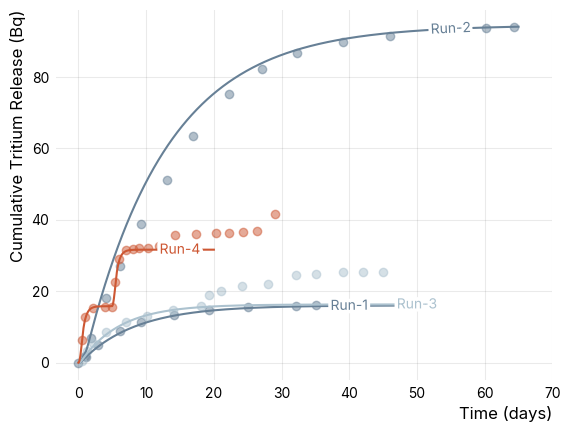

In [ ]:
plt.figure()

# run 1
model_run_1 = model_from_json(data_1l_run_1)
model_run_1.run(50 * ureg.day)

(l1,) = plot_integrated_top_release(model_run_1, label="Run-1")
scatter_stream(data_1l_run_1, "IV", color=l1.get_color(), alpha=0.5)

# run 2
model_run_2 = model_from_json(data_1l_run_2)
model_run_2.run(65 * ureg.day)
(l2,) = plot_integrated_top_release(model_run_2, label="Run-2", color=l1.get_color())
scatter_stream(data_1l_run_2, "IV", color=l2.get_color(), alpha=0.5)

# run 3
model_run_3 = model_from_json(data_1l_run_3)
model_run_3.run(50 * ureg.day)
(l3,) = plot_integrated_top_release(model_run_3, label="Run-3")
scatter_stream(data_1l_run_3, "IV", color=l3.get_color(), alpha=0.5)

# run 4
model_run_4 = model_from_json(data_1l_run_4)
model_run_4.run(20 * ureg.day)
(l4,) = plot_integrated_top_release(model_run_4, label="Run-4")
scatter_stream(data_1l_run_4, "IV", color=l4.get_color(), alpha=0.5)


plt.xlim(right=70 * ureg.day)
plt.xlabel("Time (days)", fontsize=12)
plt.ylabel("Cumulative Tritium Release (Bq)", fontsize=12)
# plt.legend()
labelLines(plt.gca().get_lines(), zorder=2.5, xvals=[40, 55, 50, 15])

plt.show()

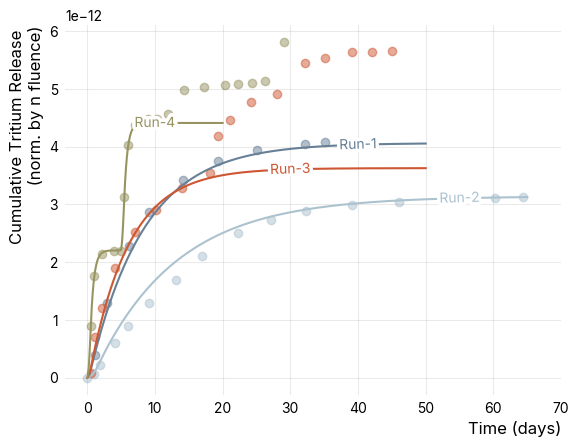

In [ ]:
from libra_toolbox.tritium.plotting import (
    LSC_SAMPLE_VOLUME,
    COLLECTION_VOLUME,
    quantity_to_activity,
)


def plot_integrated_top_release_normalised(model: Model, normalise_by=None, **kwargs):
    integrated_top = quantity_to_activity(model.integrated_release_top()).to(ureg.Bq)
    sample_activity_top = integrated_top / COLLECTION_VOLUME * LSC_SAMPLE_VOLUME
    sample_activity_top *= 1 / normalise_by
    l = plt.plot(model.times.to(ureg.day), sample_activity_top, **kwargs)
    return l


# normalise by fluence

plt.figure()
# run 1
fluence_1 = get_neutron_fluence(data_1l_run_1)
(l1,) = plot_integrated_top_release_normalised(
    model_run_1, label="Run-1", normalise_by=fluence_1
)
# norm_factor = quantity_to_activity(model_run_1.integrated_release_top()).to(ureg.Bq)[-1]
scatter_stream(
    data_1l_run_1, "IV", normalise_by=fluence_1, color=l1.get_color(), alpha=0.5
)

# run 2
fluence_2 = get_neutron_fluence(data_1l_run_2)
(l2,) = plot_integrated_top_release_normalised(
    model_run_2, label="Run-2", normalise_by=fluence_2
)
scatter_stream(
    data_1l_run_2, "IV", normalise_by=fluence_2, color=l2.get_color(), alpha=0.5
)

# run 3
fluence_3 = get_neutron_fluence(data_1l_run_3)
(l3,) = plot_integrated_top_release_normalised(
    model_run_3, label="Run-3", normalise_by=fluence_3
)
scatter_stream(
    data_1l_run_3, "IV", normalise_by=fluence_3, color=l3.get_color(), alpha=0.5
)

# run 4
fluence_4 = get_neutron_fluence(data_1l_run_4)
(l4,) = plot_integrated_top_release_normalised(
    model_run_4, label="Run-4", normalise_by=fluence_4
)
scatter_stream(
    data_1l_run_4, "IV", normalise_by=fluence_4, color=l4.get_color(), alpha=0.5
)

labelLines(plt.gca().get_lines(), zorder=2.5, xvals=[40, 55, 30, 10])


plt.xlim(right=70 * ureg.day)
plt.xlabel("Time (days)", fontsize=12)
plt.ylabel("Cumulative Tritium Release \n (norm. by n fluence)", fontsize=12)
plt.show()

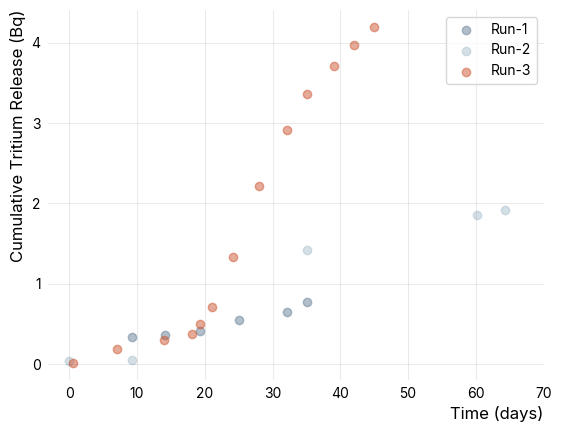

In [ ]:
scatter_stream(data_1l_run_1, "OV", color=l1.get_color(), alpha=0.5, label="Run-1")
scatter_stream(data_1l_run_2, "OV", color=l2.get_color(), alpha=0.5, label="Run-2")
scatter_stream(data_1l_run_3, "OV", color=l3.get_color(), alpha=0.5, label="Run-3")


plt.xlim(right=70 * ureg.day)
plt.ylabel("Cumulative Tritium Release (Bq)", fontsize=12)
plt.xlabel("Time (days)", fontsize=12)
plt.legend()

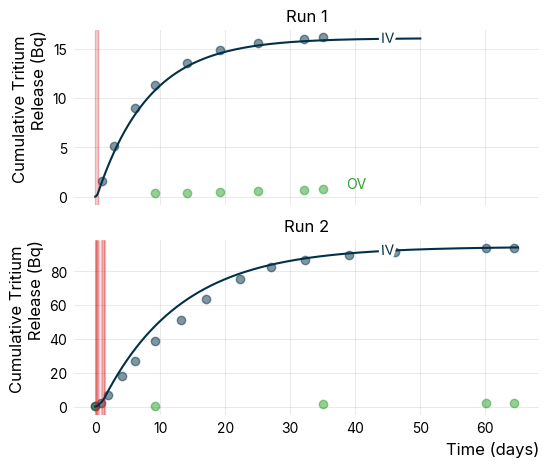

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(6, 5), sharex=True)

for i, (model_run, data, label) in enumerate(
    zip(
        [model_run_1, model_run_2],
        [data_1l_run_1, data_1l_run_2],
        ["Run 1", "Run 2"],
    )
):
    plt.sca(axs[i])
    s = scatter_stream(data, "OV", alpha=0.5, label="OV", color="tab:green")
    (l,) = plot_integrated_top_release(model_run, color="#023047", label="IV")
    scatter_stream(data, "IV", color=l.get_color(), alpha=0.5, label="IV")

    plot_irradiation(model_run, color="tab:red", alpha=0.2)

    axs[i].set_title(label)
    # axs[i].legend()

    labelLines([l], zorder=2.5, xvals=[45 * ureg.days])

    plt.annotate("OV", xy=(s.get_offsets()[-1] * 1.1), color="tab:green")

    axs[i].set_ylabel("Cumulative Tritium \n Release (Bq)", fontsize=12)

axs[-1].set_xlabel("Time (days)", fontsize=12)

plt.savefig("baby_1l_runs12_ov.svg", bbox_inches="tight")

plt.show()

/home/remidm/anaconda3/envs/baby-1l-paper/lib/python3.12/site-packages/labellines/core.py:267: UserWarning: The value at position 0 in `xvals` is outside the range of its associated line (xmin=np.float64(1.7763568394002505e-15), xmax=np.float64(20.0), xval=45). Clipping it into the allowed range.
  warnings.warn(


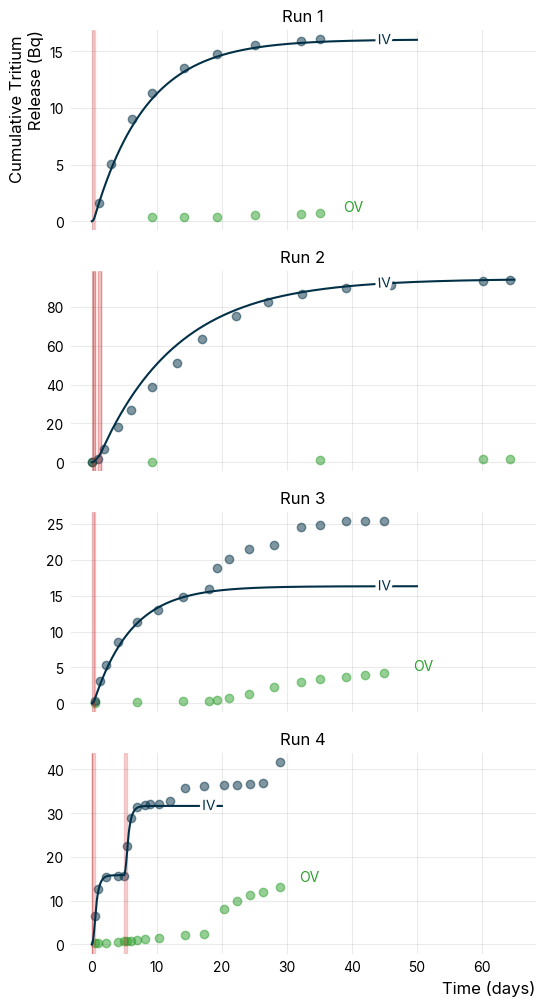

In [ ]:
fig, axs = plt.subplots(4, 1, figsize=(6, 12), sharex=True)

for i, (model_run, data, label) in enumerate(
    zip(
        [model_run_1, model_run_2, model_run_3, model_run_4],
        [data_1l_run_1, data_1l_run_2, data_1l_run_3, data_1l_run_4],
        ["Run 1", "Run 2", "Run 3", "Run 4"],
    )
):
    plt.sca(axs[i])
    s = scatter_stream(data, "OV", alpha=0.5, label="OV", color="tab:green")
    (l,) = plot_integrated_top_release(model_run, color="#023047", label="IV")
    scatter_stream(data, "IV", color=l.get_color(), alpha=0.5, label="IV")
    plot_irradiation(model_run, color="tab:red", alpha=0.2)
    axs[i].set_title(label)
    # axs[i].legend()

    labelLines([l], zorder=2.5, xvals=[45 * ureg.days])

    plt.annotate("OV", xy=(s.get_offsets()[-1] * 1.1), color="tab:green")


axs[0].set_ylabel("Cumulative Tritium \n Release (Bq)", fontsize=12)

axs[-1].set_xlabel("Time (days)", fontsize=12)

for ax in axs[1:]:
    ax.set_ylabel(None)

plt.savefig("runs_1_to_4_dynamics.pdf", bbox_inches="tight")

plt.show()

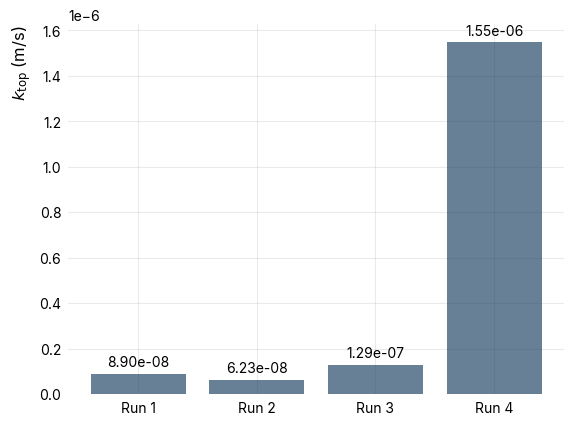

In [ ]:
k_top_values = []
for data in [data_1l_run_1, data_1l_run_2, data_1l_run_3, data_1l_run_4]:
    k_top_values.append(data["k_top"]["value"] * ureg(data["k_top"]["unit"]))

bars = plt.bar(
    ["Run 1", "Run 2", "Run 3", "Run 4"],
    k_top_values,
)
plt.bar_label(bars, fmt="%.2e", padding=3)
plt.ylabel(r"$k_\mathrm{top}$ (m/s)", fontsize=12)
plt.savefig("k_top.svg", bbox_inches="tight")
plt.show()

## Focus on run 3

In [ ]:
from datetime import datetime

general_data_run_3 = get_data(
    "https://raw.githubusercontent.com/LIBRA-project/BABY-1L-run-3/refs/heads/main/data/general.json"
)

# read start time from general.json
all_start_times = []
for generator in general_data_run_3["generators"]:
    if generator["enabled"] is False:
        continue
    for irradiation_period in generator["periods"]:
        start_time = datetime.strptime(irradiation_period["start"], "%m/%d/%Y %H:%M")
        all_start_times.append(start_time)
start_time = min(all_start_times)

gas_switch_time = datetime.strptime(
    general_data_run_3["cover_gas"]["switched_to"]["gas_switch_time"], "%m/%d/%Y %H:%M"
)
gas_switch_deltatime = gas_switch_time - start_time
gas_switch_deltatime = gas_switch_deltatime.total_seconds() * ureg.s
gas_switch_deltatime = gas_switch_deltatime.to(ureg.day)

Download successful!


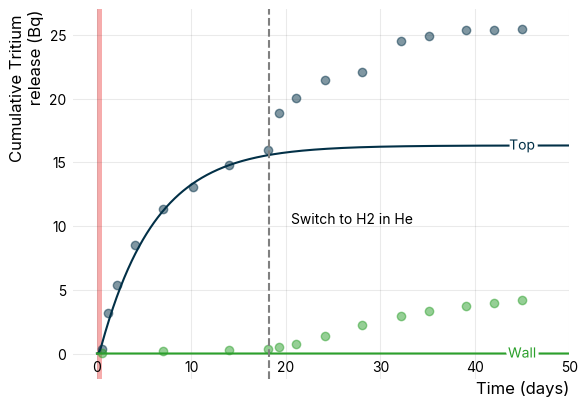

In [ ]:
from libra_toolbox.tritium.plotting import (
    plot_integrated_wall_release,
    plot_irradiation,
)

plt.figure()
(l_top,) = plot_integrated_top_release(model_run_3, label="Top", color="#023047")
(l_wall,) = plot_integrated_wall_release(model_run_3, label="Wall", color="tab:green")
plot_irradiation(model_run_3, facecolor="#EF5B5B", alpha=0.5)
labelLines(plt.gca().get_lines(), zorder=2.5, xvals=[45] * 2)

scatter_stream(data_1l_run_3, "IV", color=l_top.get_color(), alpha=0.5, label="IV")
scatter_stream(data_1l_run_3, "OV", color=l_wall.get_color(), alpha=0.5, label="OV")

plt.axvline(x=gas_switch_deltatime, color="grey", linestyle="--")

plt.annotate(
    f"Switch to H2 in He",
    (gas_switch_deltatime, 10),
    xytext=(60, 0),
    textcoords="offset points",
    ha="center",
    va="bottom",
    color="black",
)

plt.ylim(top=27, bottom=-2)
plt.xlim(right=50)
plt.xlabel("Time (days)", fontsize=12)
plt.ylabel("Cumulative Tritium \n release (Bq)", fontsize=12)

# move the xaxis to y=0
plt.gca().spines["bottom"].set_position(("data", 0))

plt.savefig("cumulative_release_run_3.pdf", bbox_inches="tight")
plt.savefig("cumulative_release_run_3.svg", bbox_inches="tight")
plt.show()

## Focus on run 4

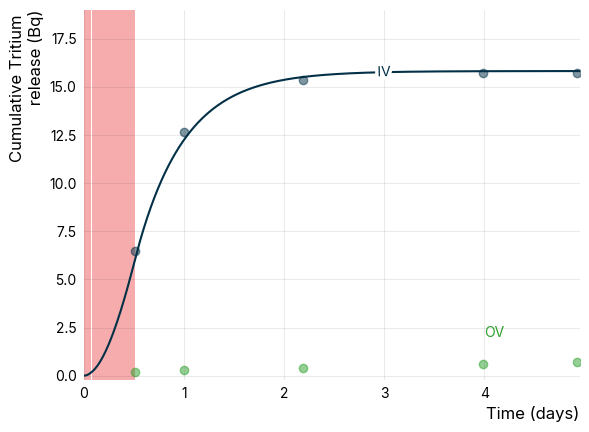

In [ ]:
plt.figure()
(l_top,) = plot_integrated_top_release(model_run_4, label="IV", color="#023047")
# (l_wall,) = plot_integrated_wall_release(model_run_4, label="OV", color="tab:green")
plot_irradiation(model_run_4, facecolor="#EF5B5B", alpha=0.5)
# plt.grid(alpha=0.5)
labelLines(plt.gca().get_lines(), zorder=2.5, xvals=[3.0] * 2)

scatter_stream(data_1l_run_4, "IV", color=l_top.get_color(), alpha=0.5, label="IV")
scatter_stream(data_1l_run_4, "OV", color=l_wall.get_color(), alpha=0.5, label="OV")

plt.annotate("OV", (4, 2), color="tab:green")

plt.xlabel("Time (days)", fontsize=12)
plt.ylabel("Cumulative Tritium \n release (Bq)", fontsize=12)

plt.xlim(0, 4.952)
plt.ylim(-0.2, 19)

plt.savefig("cumulative_release_run_4.pdf", bbox_inches="tight")
plt.savefig("cumulative_release_run_4.svg", bbox_inches="tight")
plt.show()

In [ ]:
model_run_2.A_top

<Quantity(153.93804002589985, 'centimeter ** 2')>

/home/remidm/anaconda3/envs/baby-1l-paper/lib/python3.12/site-packages/labellines/core.py:267: UserWarning: The value at position 0 in `xvals` is outside the range of its associated line (xmin=np.float64(0.0), xmax=np.float64(19.999999999999996), xval=45). Clipping it into the allowed range.
  warnings.warn(
/home/remidm/anaconda3/envs/baby-1l-paper/lib/python3.12/site-packages/labellines/core.py:267: UserWarning: The value at position 1 in `xvals` is outside the range of its associated line (xmin=np.float64(0.0), xmax=np.float64(19.999999999999996), xval=45). Clipping it into the allowed range.
  warnings.warn(


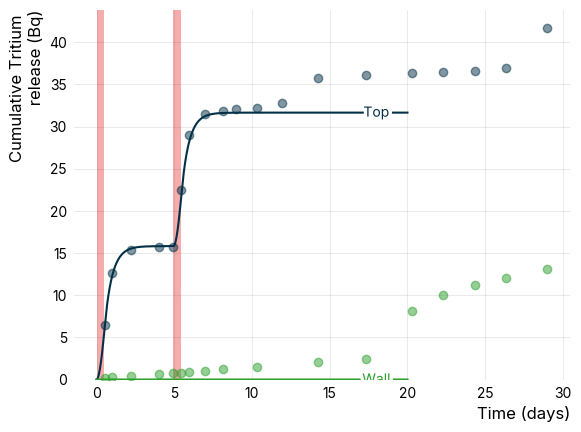

In [ ]:
plt.figure()
(l_top,) = plot_integrated_top_release(model_run_4, label="Top", color="#023047")
(l_wall,) = plot_integrated_wall_release(model_run_4, label="Wall", color="tab:green")
plot_irradiation(model_run_4, facecolor="#EF5B5B", alpha=0.5)
labelLines(plt.gca().get_lines(), zorder=2.5, xvals=[45] * 2)

scatter_stream(data_1l_run_4, "IV", color=l_top.get_color(), alpha=0.5, label="IV")
scatter_stream(data_1l_run_4, "OV", color=l_wall.get_color(), alpha=0.5, label="OV")

plt.ylim(bottom=0)
plt.xlabel("Time (days)", fontsize=12)
plt.ylabel("Cumulative Tritium \n release (Bq)", fontsize=12)

plt.savefig("cumulative_release_run_4_full.pdf", bbox_inches="tight")
plt.savefig("cumulative_release_run_4_full.svg", bbox_inches="tight")
plt.show()

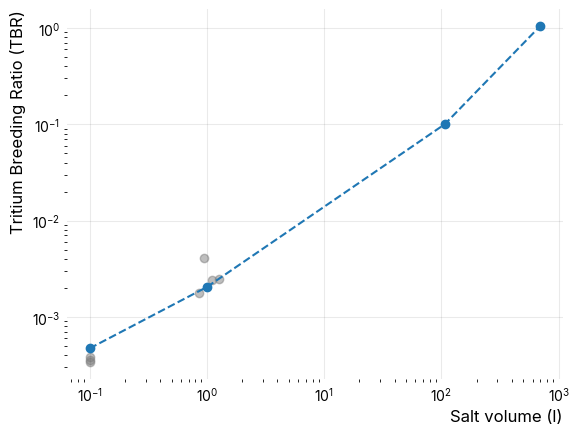

In [ ]:
plt.gca().xaxis.set_units(ureg.L)

volumes = [100 * ureg.ml, 1 * ureg.l, 107 * ureg.l, 700 * ureg.l]
expected_tbrs = [modelled_tbr_100ml, modelled_tbr_1l, 0.1, 1.05]

volumes = ureg.Quantity.from_list(volumes)

plt.plot(
    volumes,
    expected_tbrs,
    linestyle="--",
    marker="o",
    label="Expected TBR",
    color="tab:blue",
)


# add 100 mL measured TBR with jitter

x_jitter = np.random.normal(0, 0.08, size=3)
measured_tbr_100ml = list(tbr_data.values())

plt.scatter(
    (100 + x_jitter)* ureg.ml,
    measured_tbr_100ml,
    color="tab:grey",
    alpha=0.5,
)


# add 1L measured TBR with jitter

x_jitter = np.random.normal(0, 0.08, size=4)
measured_tbr_1l = [data.get("measured_TBR", {}).get("value", None) for data in [data_1l_run_1, data_1l_run_2, data_1l_run_3, data_1l_run_4]]

plt.scatter(
    (1 + x_jitter)* ureg.l,
    measured_tbr_1l,
    label="Measured TBR",
    color="tab:grey",
    alpha=0.5,
)


plt.xscale("log")
plt.yscale("log")

plt.xlabel(f"Salt volume ({plt.gca().xaxis.get_units(): ~P})", fontsize=12)
plt.ylabel("Tritium Breeding Ratio (TBR)", fontsize=12)

plt.savefig("tbr_vs_volume.svg", bbox_inches="tight")
plt.savefig("tbr_vs_volume.pdf", bbox_inches="tight")

## Sherwood number calculations

/home/remidm/anaconda3/envs/baby-1l-paper/lib/python3.12/site-packages/pybtex/plugin/__init__.py:26: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


HTM version 0.17
Run #1 k_top: 8.90e-08 meter / second
0.4 dimensionless
0.1 dimensionless
0.2 dimensionless
1.5 dimensionless
1.9 dimensionless
0.9 dimensionless
Average Sh number: 0.8
Median Sh number: 0.7
Stdev Sh number: 0.7
Run #2 k_top: 6.23e-08 meter / second
0.3 dimensionless
0.1 dimensionless
0.1 dimensionless
1.0 dimensionless
1.3 dimensionless
0.6 dimensionless
Average Sh number: 0.6
Median Sh number: 0.5
Stdev Sh number: 0.5
Run #3 k_top: 1.29e-07 meter / second
0.7 dimensionless
0.2 dimensionless
0.3 dimensionless
2.1 dimensionless
2.8 dimensionless
1.3 dimensionless
Average Sh number: 1.2
Median Sh number: 1.0
Stdev Sh number: 1.0
Run #4 k_top: 1.55e-06 meter / second
7.8 dimensionless
1.8 dimensionless
3.0 dimensionless
25.7 dimensionless
33.5 dimensionless
15.9 dimensionless
Average Sh number: 14.6
Median Sh number: 11.9
Stdev Sh number: 11.7


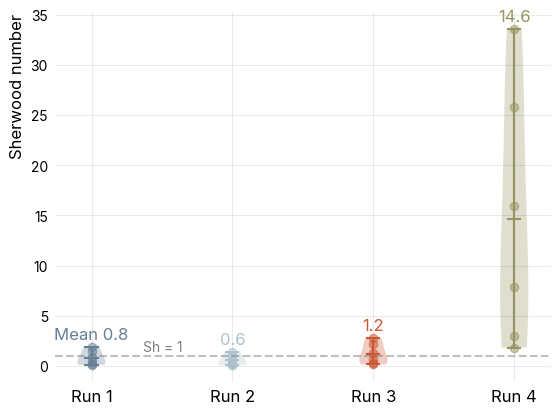

In [ ]:
import h_transport_materials as htm
print(f"HTM version {htm.__version__}")
flibe_diffusivities = htm.diffusivities.filter(material=[htm.FLIBE, htm.FLINAK])
temp = htm.ureg.Quantity(650, htm.ureg.degC).to(htm.ureg.K)

for i, model in enumerate([model_run_1, model_run_2, model_run_3, model_run_4]):
    print(f"Run #{i+1} k_top: {model.k_top.to(htm.ureg.m / htm.ureg.s):.2e}")
    L = model.height
    sh_numbers = []
    for flibe_D in flibe_diffusivities:
        if flibe_D.range[0] <= temp <= flibe_D.range[1]:
            D = flibe_D.value(temp).magnitude * ureg.m**2 * ureg.s**-1
            sherwood_nb = model.k_top/(D /L)
            sh_numbers.append(sherwood_nb.to(ureg.dimensionless).magnitude)
            print(f"{sherwood_nb.to(ureg.dimensionless):.1f}")

    c=plt.scatter(np.ones_like(sh_numbers) * i, sh_numbers, label=f"Run {i+1}", alpha=0.5)
    plt.violinplot(
        sh_numbers,
        positions=[i],
        showmeans=True,
        showextrema=True,
        # showmedians=True,
        widths=0.2,
    )

    print(f"Average Sh number: {np.mean(sh_numbers):.1f}")
    print(f"Median Sh number: {np.median(sh_numbers):.1f}")
    print(f"Stdev Sh number: {np.std(sh_numbers):.1f}")
    # on top of each violin plot, add the mean value

    if i == 0:
        annotation = f"Mean {np.mean(sh_numbers):.1f}"
    else:
        annotation = f"{np.mean(sh_numbers):.1f}"
    plt.text(
        i,
        np.max(sh_numbers) + 0.5,
        annotation,
        ha="center",
        va="bottom",
        fontsize=12,
        color=c.get_facecolor(),
        alpha=1.0,
    )

plt.axhline(y=1.0, color="grey", linestyle="--", alpha=0.5)
plt.annotate(
    "Sh = 1",
    xy=(0.5, 1.05),
    xytext=(0.5, 1.2),
    textcoords="offset points",
    ha="center",
    va="bottom",
    color="grey",
)

plt.xticks(
    np.arange(4), [f"Run {i+1}" for i in range(4)], fontsize=12
)
plt.ylabel("Sherwood number", fontsize=12)



plt.savefig("sherwood_numbers.pdf", bbox_inches="tight")